In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Data selection and preprocessing:

In [2]:
ratings = pd.read_csv('ratings.csv')

In [3]:
def train_test_split_user(ratings, test_size=0.2):
    train_list = []
    test_list = []

    for user_id in ratings['userId'].unique():
        user_data = ratings[ratings['userId'] == user_id]
        if len(user_data) >= 5:
            train_data, test_data = train_test_split(user_data, test_size=test_size, random_state=42)
            train_list.append(train_data)
            test_list.append(test_data)
        else:
            train_list.append(user_data)
    
    train = pd.concat(train_list)
    test = pd.concat(test_list)
    return train, test

train_data, test_data = train_test_split_user(ratings)
train_data = train_data.drop(columns=['timestamp'])
test_data = test_data.drop(columns=['timestamp'])
print(train_data.head())

     userId  movieId  rating
55        1     1031     5.0
230       1     4006     4.0
69        1     1197     5.0
168       1     2596     5.0
109       1     1777     4.0


In [4]:
def quantile_normalize(ratings):
    normalized_ratings = ratings.groupby('userId')['rating'].transform(lambda x: quantile_scale(x))
    ratings['rating'] = normalized_ratings
    return ratings

def quantile_scale(ratings):
    sorted_ratings = np.sort(ratings)
    ranks = np.argsort(np.argsort(ratings)) 
    return np.interp(ratings, sorted_ratings, sorted_ratings)
train_data = quantile_normalize(train_data)

In [5]:
train_data['weight'] = train_data.groupby('movieId')['movieId'].transform('count')
train_data['weight'] = train_data['weight'] / train_data['weight'].sum()
train_data = train_data.sample(frac=1, weights=train_data['weight'], random_state=42)

# Rating Prediction

In [6]:
class MF():
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_movies = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_movies, self.K))

        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_movies)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_movies)
            if self.R[i, j] > 0
        ]

        error_list = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            error_list.append((self.mae(), self.rmse()))
            print("Iteration: %d ; mae = %.4f ; rmse = %.4f" % (i+1, error_list[-1][0], error_list[-1][1]))

        return error_list
          
    def mae(self):
        xs, ys = self.R.nonzero() 
        predicted = self.full_matrix()  
        error = 0
        
        for x, y in zip(xs, ys):
            error += abs(self.R[x, y] - predicted[x, y])  
        
        return error / len(xs)
    
    def rmse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)

        return np.sqrt(error/len(xs))

    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            P_i = self.P[i, :].copy()
            Q_j = self.Q[j, :].copy()

            self.P[i, :] += self.alpha * (e * Q_j - self.beta * P_i)
            self.Q[j, :] += self.alpha * (e * P_i - self.beta * Q_j)

    def get_rating(self, i, j):
        m_b = self.b_i[j] if j < len(self.b_i) else 0
        l_i = self.Q[j, :].T if j < len(self.Q) else np.mean(self.Q, axis=0) 
        prediction = self.b + self.b_u[i] + m_b + self.P[i, :].dot(l_i)
        return prediction

    def full_matrix(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)


In [7]:
user_ids = train_data['userId'].unique()  
movie_ids = train_data['movieId'].unique()  

user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

R = np.zeros((len(user_ids), len(movie_ids)))

for row in train_data.itertuples():
    user_idx = user_to_idx[row.userId]
    movie_idx = movie_to_idx[row.movieId]
    R[user_idx, movie_idx] = row.rating

mf = MF(R, K=50, alpha=0.01, beta=0.05, iterations=150)

errors = mf.train()

Iteration: 1 ; mae = 0.6998 ; rmse = 0.8994
Iteration: 2 ; mae = 0.6792 ; rmse = 0.8758
Iteration: 3 ; mae = 0.6660 ; rmse = 0.8620
Iteration: 4 ; mae = 0.6577 ; rmse = 0.8527
Iteration: 5 ; mae = 0.6521 ; rmse = 0.8458
Iteration: 6 ; mae = 0.6469 ; rmse = 0.8400
Iteration: 7 ; mae = 0.6434 ; rmse = 0.8350
Iteration: 8 ; mae = 0.6395 ; rmse = 0.8310
Iteration: 9 ; mae = 0.6369 ; rmse = 0.8272
Iteration: 10 ; mae = 0.6341 ; rmse = 0.8237
Iteration: 11 ; mae = 0.6310 ; rmse = 0.8204
Iteration: 12 ; mae = 0.6288 ; rmse = 0.8172
Iteration: 13 ; mae = 0.6269 ; rmse = 0.8140
Iteration: 14 ; mae = 0.6239 ; rmse = 0.8108
Iteration: 15 ; mae = 0.6208 ; rmse = 0.8067
Iteration: 16 ; mae = 0.6172 ; rmse = 0.8024
Iteration: 17 ; mae = 0.6154 ; rmse = 0.7983
Iteration: 18 ; mae = 0.6106 ; rmse = 0.7923
Iteration: 19 ; mae = 0.6060 ; rmse = 0.7866
Iteration: 20 ; mae = 0.6011 ; rmse = 0.7792
Iteration: 21 ; mae = 0.5954 ; rmse = 0.7714
Iteration: 22 ; mae = 0.5896 ; rmse = 0.7631
Iteration: 23 ; mae

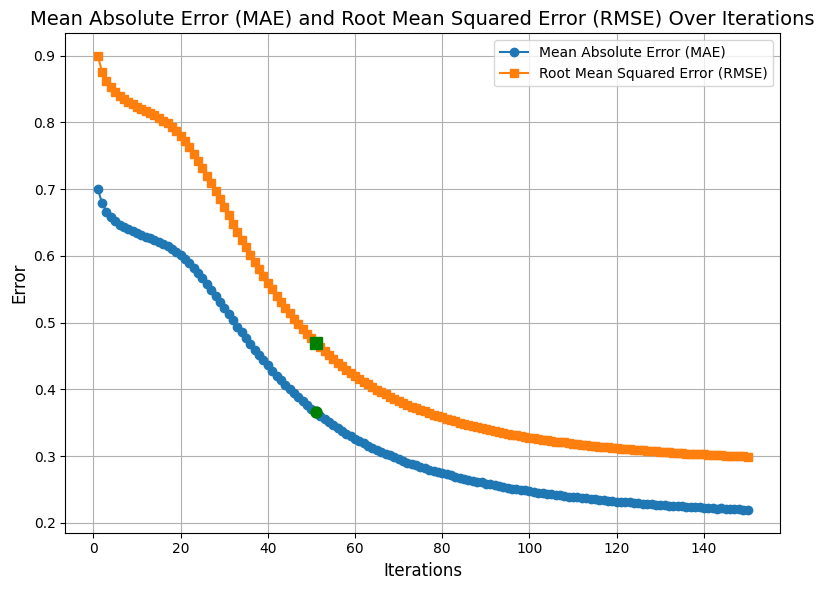

In [8]:
plt.figure(figsize=(8, 6))

highlight_epoch = 50

iterations = range(1, len(errors) + 1)
mae = [error[0] for error in errors]
rmse = [error[1] for error in errors]

plt.plot(iterations, mae, label='Mean Absolute Error (MAE)', marker='o')
plt.plot(iterations, rmse, label='Root Mean Squared Error (RMSE)', marker='s')

plt.plot(iterations[highlight_epoch], mae[highlight_epoch], 'go', markersize=8)
plt.plot(iterations[highlight_epoch], rmse[highlight_epoch], 'gs', markersize=8)

plt.title('Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) Over Iterations', fontsize=14)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()

plt.show()

In [9]:
def test_model(mf_model, test_data, user_to_idx, movie_to_idx):
    squared_error = 0
    absolute_error = 0
    n = len(test_data)

    for _, row in test_data.iterrows():
        uid = int(row['userId'])
        mid = int(row['movieId'])
             
        user_id = int(user_to_idx[uid])
        movie_id = int(movie_to_idx[mid]) if mid in movie_to_idx else len(movie_to_idx)
        actual_rating = row['rating']
        
        predicted_rating = mf_model.get_rating(user_id, movie_id)
        
        squared_error += (actual_rating - predicted_rating) ** 2
        
        absolute_error += abs(actual_rating - predicted_rating)
    
    rmse = np.sqrt(squared_error / n)
    mae = absolute_error / n

    return rmse, mae

In [10]:
rmse, mae = test_model(mf, test_data, user_to_idx, movie_to_idx)
print("Test RMSE:", rmse)
print("Test MAE:", mae)

Test RMSE: 0.8708252273635297
Test MAE: 0.6674725924996017


# Recommendations

In [11]:
def unwatched_movies(ratings):
    all_movie_ids = set(ratings['movieId'])
    user_to_unwatched_movies = {}

    for user_id in ratings['userId'].unique():
        user = ratings[ratings['userId'] == user_id]
        watched_movies = set(user['movieId'])
        unwatched_movies = all_movie_ids - watched_movies
        user_to_unwatched_movies[user_id] = unwatched_movies

    return user_to_unwatched_movies

In [12]:
def recommend_movies(mf_model, user_to_idx, movie_to_idx, n=10):
    unwatched = unwatched_movies(train_data)
    recommendations = {}

    for user_id in sorted(user_to_idx.keys()):
        user_idx = user_to_idx[user_id]
        predictions = mf_model.full_matrix()[user_idx]
        recommended_movie_idxs = np.argsort(predictions)[::-1]
        recommended_movies = [k for k, v in movie_to_idx.items() if v in recommended_movie_idxs and k in unwatched[user_id]][:n]
        recommendations[user_id] = recommended_movies
        print(f"User {user_id}: {recommended_movies}")

    return recommendations

top_10_recommendations_v1 = recommend_movies(mf, user_to_idx, movie_to_idx)

User 1: [539, 72226, 161, 6936, 1036, 4979, 344, 34, 40815, 2396]
User 2: [539, 72226, 733, 161, 6936, 1036, 1270, 1291, 593, 500]
User 3: [539, 72226, 733, 161, 6936, 1036, 1270, 1291, 593, 500]
User 4: [72226, 733, 161, 6936, 1036, 1270, 1291, 500, 50, 4979]
User 5: [539, 72226, 733, 161, 6936, 1036, 1270, 1291, 593, 500]
User 6: [539, 72226, 733, 6936, 1036, 1270, 1291, 4979, 344, 40815]
User 7: [539, 72226, 733, 161, 6936, 1036, 1270, 1291, 500, 4979]
User 8: [72226, 733, 161, 6936, 1036, 1270, 1291, 4979, 344, 40815]
User 9: [539, 72226, 733, 161, 6936, 1036, 1291, 593, 500, 50]
User 10: [539, 72226, 733, 161, 6936, 1036, 1270, 1291, 593, 500]
User 11: [539, 72226, 161, 6936, 1036, 1270, 1291, 500, 50, 4979]
User 12: [539, 72226, 733, 161, 6936, 1036, 1270, 1291, 593, 500]
User 13: [539, 72226, 733, 161, 6936, 1036, 1270, 1291, 593, 500]
User 14: [72226, 733, 161, 6936, 1036, 1270, 1291, 500, 50, 4979]
User 15: [539, 72226, 733, 161, 6936, 1036, 1270, 1291, 593, 500]
User 16: [539

In [13]:
def enhanced_recommend_movies(mf_model, user_to_idx, movie_to_idx, train_data, n=10, 
                            user_rating_threshold=None, min_ratings=10, popularity_weight=0.4, confidence_weight=0.3):
    movie_stats = train_data.groupby('movieId').agg({
        'rating': ['count']
    }).droplevel(0, axis=1)
    
    valid_movies = set(movie_stats[movie_stats['count'] >= min_ratings].index)
    
    if user_rating_threshold is None:
        user_rating_threshold = {}
        for user_id in train_data['userId'].unique():
            user_ratings = train_data[train_data['userId'] == user_id]
            user_rating_threshold[user_id] = user_ratings['rating'].mean() + 0.5 * user_ratings['rating'].std()

    user_preferences = {}
    for user_id in train_data['userId'].unique():
        user_ratings = train_data[train_data['userId'] == user_id]
        liked_movies = user_ratings[user_ratings['rating'] >= user_rating_threshold[user_id]]['movieId']
        if len(liked_movies) > 0:
            user_preferences[user_id] = liked_movies.tolist()
            
    
    unwatched = unwatched_movies(train_data)
    recommendations = {}
    for user_id in sorted(user_to_idx.keys()):
        if user_id not in user_preferences:
            continue
            
        user_idx = user_to_idx[user_id]
        user_unwatched = unwatched[user_id].intersection(valid_movies)
        
        if not user_unwatched:
            continue
            
        predictions = []
        for movie_id in user_unwatched:
            if movie_id in movie_to_idx:
                movie_idx = movie_to_idx[movie_id]
                pred_rating = mf_model.get_rating(user_idx, movie_idx)
                
                confidence = 1 - (1 / (1 + movie_stats.loc[movie_id, 'count'] / 100))
                popularity = movie_stats.loc[movie_id, 'count'] / movie_stats['count'].max()

                adjusted_score = ((1 - popularity_weight - confidence_weight) * pred_rating + 
                                confidence_weight * confidence + 
                                popularity_weight * popularity)
                
                predictions.append((movie_id, adjusted_score))
        
        top_n_movie_ids = [
            movie_id for movie_id, _ in 
            sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
        ]
        
        recommendations[user_id] = top_n_movie_ids
        print(f"User {user_id}: {top_n_movie_ids}")
    
    return recommendations

top_10_recommendations_v2 = enhanced_recommend_movies(mf, user_to_idx, movie_to_idx, train_data, n=10)

User 1: [296, 318, 260, 858, 4993, 48516, 588, 1210, 7153, 1704]
User 2: [2571, 296, 47, 593, 260, 356, 377, 858, 2959, 1196]
User 3: [7153, 6539, 5349, 4993, 780, 296, 2571, 1240, 593, 112852]
User 4: [318, 260, 356, 527, 858, 1221, 1214, 150, 2571, 58559]
User 5: [47, 260, 593, 356, 2571, 858, 2959, 32, 2858, 541]
User 6: [2571, 1270, 260, 1198, 377, 4306, 1291, 5952, 1210, 3578]
User 7: [2571, 318, 1036, 296, 1198, 110, 589, 2028, 480, 1214]
User 8: [608, 318, 356, 527, 4034, 2959, 1196, 2028, 6377, 589]
User 9: [318, 1196, 1136, 356, 110, 593, 296, 7153, 260, 2571]
User 10: [260, 318, 150, 589, 1210, 1196, 364, 4306, 5952, 10]
User 11: [318, 527, 2571, 1198, 110, 260, 1196, 50, 296, 1270]
User 12: [318, 2571, 110, 356, 32, 296, 260, 593, 1210, 150]
User 13: [296, 318, 260, 110, 356, 1196, 858, 2858, 593, 2959]
User 14: [2858, 2571, 1198, 1580, 260, 589, 858, 904, 4226, 527]
User 15: [924, 593, 608, 110, 858, 50, 1270, 590, 541, 1221]
User 16: [593, 589, 260, 32, 110, 1265, 5952, 63

In [14]:
def dcg(recommended_movies, actual_movies):
    dcg_value = 0.0
    for i, movie in enumerate(recommended_movies):
        if movie in actual_movies:
            dcg_value += 1 / np.log2(i + 2)  
    return dcg_value

def idcg(actual_movies, length):
    idcg_value = 0.0
    for i in range(min(len(actual_movies), length)):
        idcg_value += 1 / np.log2(i + 2)
    return idcg_value

def recommendation_performance(recommendations, test_data):
    running_precision, running_recall, running_ndcg = 0, 0, 0

    for user_id, recommended_movies in recommendations.items():
        actual_movies = test_data[test_data['userId'] == user_id]['movieId']

        intersection = len(set(recommended_movies) & set(actual_movies))
        precision = (intersection / len(recommended_movies)) * 100
        recall = (intersection / len(actual_movies)) * 100

        running_precision += precision
        running_recall += recall

        dcg_value = dcg(list(recommended_movies), list(actual_movies))
        idcg_value = idcg(list(actual_movies), len(recommended_movies))
        ndcg = dcg_value / idcg_value if idcg_value > 0 else 0
        running_ndcg += ndcg

    precision = running_precision / len(recommendations)
    recall = running_recall / len(recommendations)
    f_measure = 2 * (precision * recall) / (precision + recall)
    ndcg = running_ndcg / len(recommendations)

    return precision, recall, f_measure, ndcg

top_10_recommendations = top_10_recommendations_v2
print("Precision \t%.4f%%\nRecall \t\t%.4f%%\nF-Measure \t%.4f%%\nNDCG \t\t%.4f" % recommendation_performance(top_10_recommendations, test_data))

Precision 	16.0265%
Recall 		6.7157%
F-Measure 	9.4652%
NDCG 		0.1873
